In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

In [2]:
# DON'T FORGET TO MODIFY cuda:1 ACCORDING TO YOUR CONFIGURATION
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Let's use {}".format(device))

Let's use cuda:1


# Distribution functions (from *samplers.py*)

In [3]:
def distribution1(x, batch_size=512):
    # Distribution defined as (x, U(0,1)). Can be used for question 3
    while True:
        yield (np.array(
            [(x, random.uniform(0, 1)) for _ in range(batch_size)]))

In [4]:
def distribution2(batch_size=512):
    # High dimension uniform distribution
    while True:
        yield (np.random.uniform(0, 1, (batch_size, 2)))

# Question 1, 2, 3

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, Wasserstein):
        super(Discriminator, self).__init__()
        self.Wasserstein = Wasserstein
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.map1(x))
        x = self.relu(self.map2(x))
        return self.map3(x) if self.Wasserstein else self.sigmoid(self.map3(x))

    def JSD_objective(self, x, y):
        return math.log(2) + 0.5 * (torch.mean(torch.log(self.forward(
            x)))) + 0.5 * (torch.mean(torch.log(1 - self.forward(y))))

    # Calculates the gradient penalty loss for WGAN GP
    def gradient_penalty(self, x, y):
        # Random weight term for interpolation between real and fake samples
        alpha = torch.empty_like(x).uniform_(0, 1)
        # Get random interpolation between real and fake samples
        interpolates = (alpha * x + ((1 - alpha) * y)).requires_grad_(True)
        interpolates_forward = self.forward(interpolates)
        # need a fake grad output
        fake = torch.ones_like(interpolates_forward)
        # Get gradient w.r.t. interpolates
        gradients = autograd.grad(
            outputs=interpolates_forward,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            only_inputs=True)[0]
        return ((torch.norm(gradients, p=2, dim=1) - 1)**2).mean()

    def WD_objective(self, x, y):
        lambda_gp = 10
        return torch.mean(self.forward(x)) - torch.mean(
            self.forward(y)) - lambda_gp * self.gradient_penalty(x, y)

    def criterion(self, x, y):
        return -self.WD_objective(
            x, y) if self.Wasserstein else -self.JSD_objective(x, y)

    def evaluate(self, x, y):
        with torch.no_grad():
            return torch.mean(self.forward(x)) - torch.mean(
                self.forward(y)) if self.Wasserstein else math.log(2) + 0.5 * (
                    torch.mean(torch.log(self.forward(x)))) + 0.5 * (
                        torch.mean(torch.log(1 - self.forward(y))))

In [6]:
def distance_estimate(dist1, dist2, n_epochs=1000, Wasserstein=False):
    model = Discriminator(2, 64, 1, Wasserstein).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    for i, (d1, d2) in enumerate(zip(dist1, dist2)):
        if i > n_epochs:
            break
        x = torch.from_numpy(d1).float().to(device)
        y = torch.from_numpy(d2).float().to(device)
        optimizer.zero_grad()
        loss = model.criterion(x, y)
        loss.backward()
        optimizer.step()
    return model.evaluate(x, y).item()

In [7]:
JSD, W = [], []
phi = np.arange(-1, 1.1, 0.1)

for i, p in enumerate(phi, 1):
    print("\rStep {:3d}/{:3d}".format(i, len(phi)), end="")
    JSD.append(distance_estimate(distribution1(0, 1024), distribution1(p, 1024), 1000, False))
    W.append(distance_estimate(distribution1(0, 1024), distribution1(p, 1024), 1000, True))

Step  21/ 21

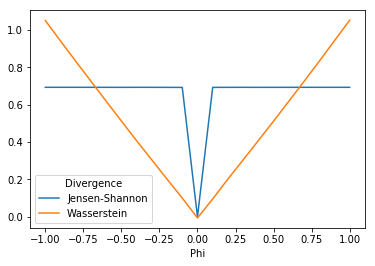

In [8]:
plt.plot(phi, JSD, label="Jensen-Shannon")
plt.plot(phi, W, label="Wasserstein")
plt.legend(title="Divergence")
plt.xlabel("Phi")
plt.show()